In [423]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from matplotlib.pyplot import imshow
import numpy as np
import fnmatch
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
import pylab
import pickle
from tqdm import tqdm
import datetime
import matplotlib.mlab as mlab
from scipy.stats import norm



pylab.rcParams['figure.figsize'] = (10.0, 8.0)
%matplotlib inline

In [3]:
#connect to database
dbname = 'coffee_db'
username = 'emclinden'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print engine.url

postgres://emclinden@localhost/coffee_db


In [6]:
sql_query = """
SELECT * FROM image_stats_wmeta;
"""
pp = pd.read_sql_query(sql_query,engine)
qr = pp[pp.cluster_member == 0] #mostly cups

In [11]:
qr.columns.values

array([u'level_0', u'index', u'picture_id', u'user_id', u'static_file',
       u'date_posted', u'n_favs', u'n_views', u'n_comments', u'tag_raw',
       u'tag_text', u'latitude', u'longitude', u'aperture',
       u'brightness_value', u'date_taken', u'time_taken', u'flash',
       u'iso_speed', u'camera_model', u'subject_area', u'subject_distance',
       u'resolution_units', u'x_res', u'y_res', u'RGB_1', u'RGB_2',
       u'RGB_3', u'brightness', u'contrast', u'n_edges', u'n_foreground',
       u'n_corners', u'n_lines', u'color_fraction', u'nbuckets',
       u'cluster_member', u'exposure', u'focal_length', u'camera1',
       u'camera2', u'camera3', u'camera4'], dtype=object)

In [ ]:
bright = np.log10(qr.brightness)
contrast = np.log10(qr.contrast)
corn = np.log10(qr.n_corners)
line = np.log10(qr.n_lines)
foc = np.log10(qr.focal_length)

In [ ]:
time = []
for q in qr.date_posted:
    a = datetime.datetime.fromtimestamp(int(q)).strftime('%Y-%m-%d %H:%M:%S')
    b = a.split(' ')[1]
    time.append(float(b.split(':')[0]) +float(b.split(':')[1])/60.)
log_time = np.log10(time)

In [73]:
y = np.asarray(qr.n_favs).astype('float') / np.asarray(qr.n_views).astype('float')
ly = np.log10(y)

In [84]:
x = pd.DataFrame()
x['bright'] = bright
x['contrast'] = contrast
x['corners'] = corn
x['line'] = line
x['focal'] = foc
x['foreground'] = qr.n_foreground
x['edges'] = qr.n_edges
x['color_frac'] = qr.color_fraction
x['nbuckets'] = qr.nbuckets
x['exp'] = qr.exposure
x['time'] = time
x['log_time'] = log_time
x['camera1'] = qr.camera1
x['camera2'] = qr.camera2
x['camera3'] = qr.camera3
x['camera4'] = qr.camera4
x['popularity'] = y

In [161]:
train, test = train_test_split(x, test_size = 0.1)
# ,'camera1','camera2','camera3','camera4'
xtrain = train[['bright','contrast','corners','foreground','edges','color_frac','nbuckets','exp','time','camera1','camera2','camera3','camera4']]
ytrain = train[['popularity']]
ytrain = np.asarray(ytrain).ravel()

xval = test[['bright','contrast','corners','foreground','edges','color_frac','nbuckets','exp','time','camera1','camera2','camera3','camera4']]
yval = test[['popularity']]
yval = np.asarray(yval).ravel()

#gradient boosted regression
gbr = GradientBoostingRegressor(n_estimators=100) #maybe experiment on alpha
gbr.fit(xtrain, ytrain)
feat=gbr.feature_importances_
r2self=gbr.score(xtrain,ytrain)
r2val=gbr.score(xval,yval)
print r2self
print r2val
print feat

0.281587937384
-0.00915852080491
[ 0.10939947  0.03084169  0.15727999  0.1344996   0.12763406  0.09576091
  0.02867077  0.11486878  0.15356386  0.01620638  0.00512963  0.00965694
  0.01648793]


In [179]:
train, test = train_test_split(x, test_size = 0.2)
# ,'camera1','camera2','camera3','camera4'
xtrain = train[['bright','contrast','corners','foreground','edges','color_frac','nbuckets','exp','time']]
ytrain = train[['popularity']]
ytrain = np.asarray(ytrain).ravel()

xval = test[['bright','contrast','corners','foreground','edges','color_frac','nbuckets','exp','time']]
yval = test[['popularity']]
yval = np.asarray(yval).ravel()

#gradient boosted regression
gbr = GradientBoostingRegressor(n_estimators=100) #maybe experiment on alpha
gbr.fit(xtrain, ytrain)
feat=gbr.feature_importances_
r2self=gbr.score(xtrain,ytrain)
r2val=gbr.score(xval,yval)
print r2self
print r2val
print feat

0.313561380243
-0.102251810153
[ 0.14587412  0.03300468  0.14485786  0.15749165  0.17048526  0.10470418
  0.03996139  0.0741979   0.12942296]


In [297]:
train, test = train_test_split(x, test_size = 0.2)
# ,'camera1','camera2','camera3','camera4'
xtrain = train[['bright','corners','foreground','edges','color_frac','exp','time']]
ytrain = train[['popularity']]
ytrain = np.asarray(ytrain).ravel()

xval = test[['bright','corners','foreground','edges','color_frac','exp','time']]
yval = test[['popularity']]
yval = np.asarray(yval).ravel()

#gradient boosted regression
gbr = GradientBoostingRegressor(n_estimators=100) #maybe experiment on alpha
gbr.fit(xtrain, ytrain)
feat=gbr.feature_importances_
r2self=gbr.score(xtrain,ytrain)
r2val=gbr.score(xval,yval)
print r2self
print r2val
print feat

0.323523177298
-0.165395975419
[ 0.14038929  0.14387923  0.17799966  0.19078908  0.10292513  0.08853689
  0.15548072]


In [219]:
with open('gbr_0p3_0p006.pickle', 'wb') as f:
       pickle.dump(gbr, f)
with open('gbr_xtrain_0p3_0p006.pickle', 'wb') as f:
       pickle.dump(xtrain, f)
with open('gbr_ytrain_0p3_0p006.pickle', 'wb') as f:
       pickle.dump(ytrain, f)
with open('gbr_xval_0p3_0p006.pickle', 'wb') as f:
       pickle.dump(xval, f)
with open('gbr_yval_0p3_0p006.pickle', 'wb') as f:
       pickle.dump(yval, f) 


In [400]:
with open('gbr_0p3_0p006.pickle', 'rb') as f:
      rgbr = pickle.load(f)
with open('gbr_xval_0p3_0p006.pickle', 'rb') as f:
      rxval = pickle.load(f)
with open('gbr_yval_0p3_0p006.pickle', 'rb') as f:
      ryval = pickle.load(f)


r2val = rgbr.score(rxval,ryval)
ft = rgbr.feature_importances_

In [ ]:
yy = pd.DataFrame()
yy['ryval'] = ryval

r2 = []
for i in range(0,1000):
    y = yy.reindex(np.random.permutation(yy.index))
    r = rgbr.score(rxval,y)
    r2.append(r)

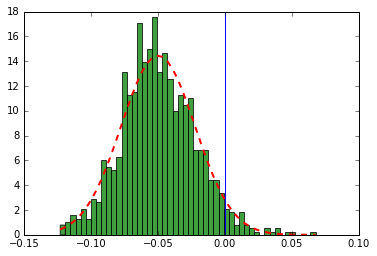

In [436]:
rr = np.asarray(r2)
np.histogram(rr)
hist, bins = np.histogram(rr,bins=20)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
n, bins, patches = plt.hist(rr, 50, normed=1, facecolor='green', alpha=0.75)

(mu, sigma) = norm.fit(rr)
yfit = mlab.normpdf( bins, mu, sigma)
y = mlab.normpdf( bins, mu, sigma)
plt.plot(bins, y, 'r--', linewidth=2)
plt.plot([0,0],[0,18],'b')
plt.show()

In [430]:
rr_sorted = np.sort(rr)
rr_sorted[25:976]

array([ -1.04058313e-01,  -1.03788653e-01,  -1.03352424e-01,
        -1.02583802e-01,  -1.01939328e-01,  -1.00180696e-01,
        -9.96983586e-02,  -9.94768363e-02,  -9.93915021e-02,
        -9.92674311e-02,  -9.86808724e-02,  -9.83511981e-02,
        -9.79037849e-02,  -9.76534632e-02,  -9.74626923e-02,
        -9.71665331e-02,  -9.69300509e-02,  -9.57782717e-02,
        -9.57527491e-02,  -9.48742953e-02,  -9.46552066e-02,
        -9.42612745e-02,  -9.38220869e-02,  -9.37158440e-02,
        -9.29290452e-02,  -9.28842660e-02,  -9.26317997e-02,
        -9.23216853e-02,  -9.23025342e-02,  -9.22099491e-02,
        -9.21549839e-02,  -9.20430128e-02,  -9.16792812e-02,
        -9.15373489e-02,  -9.11622049e-02,  -9.10403543e-02,
        -9.09968158e-02,  -9.08424297e-02,  -9.02238554e-02,
        -9.00295833e-02,  -8.99679366e-02,  -8.96887574e-02,
        -8.96286679e-02,  -8.95652336e-02,  -8.94070264e-02,
        -8.91924821e-02,  -8.90231922e-02,  -8.89885362e-02,
        -8.87596749e-02,

In [183]:
train, test = train_test_split(x, test_size = 0.1)
# ,'camera1','camera2','camera3','camera4'
xtrain = train[['bright','corners','foreground','edges','color_frac','time']]
ytrain = train[['popularity']]
ytrain = np.asarray(ytrain).ravel()

xval = test[['bright','corners','foreground','edges','color_frac','time']]
yval = test[['popularity']]
yval = np.asarray(yval).ravel()

#gradient boosted regression
gbr = GradientBoostingRegressor(n_estimators=100) #maybe experiment on alpha
gbr.fit(xtrain, ytrain)
feat=gbr.feature_importances_
r2self=gbr.score(xtrain,ytrain)
r2val=gbr.score(xval,yval)
print r2self
print r2val
print feat

0.27834833424
-0.0436302872205
[ 0.24553973  0.14839309  0.17890422  0.14454626  0.12223414  0.16038256]


In [177]:
train, test = train_test_split(x, test_size = 0.3)
# ,'camera1','camera2','camera3','camera4'
xtrain = train[['bright','foreground','color_frac','nbuckets','exp','time']]
ytrain = train[['popularity']]
ytrain = np.asarray(ytrain).ravel()

xval = test[['bright','foreground','color_frac','nbuckets','exp','time']]
yval = test[['popularity']]
yval = np.asarray(yval).ravel()

#gradient boosted regression
gbr = GradientBoostingRegressor(n_estimators=100) #maybe experiment on alpha
gbr.fit(xtrain, ytrain)
feat=gbr.feature_importances_
r2self=gbr.score(xtrain,ytrain)
r2val=gbr.score(xval,yval)
print r2self
print r2val
print feat

0.298227311679
-0.0687047786848
[ 0.17924674  0.26144792  0.20584381  0.04876691  0.10052375  0.20417087]


In [394]:
train, test = train_test_split(x, test_size = 0.1)
# ,'camera1','camera2','camera3','camera4'
xtrain = train[['bright','edges','time','foreground']]
ytrain = train[['popularity']]
ytrain = np.asarray(ytrain).ravel()

xval = test[['bright','edges','time','foreground']]
yval = test[['popularity']]
yval = np.asarray(yval).ravel()

#gradient boosted regression
gbr = GradientBoostingRegressor(n_estimators=100) #maybe experiment on alpha
gbr.fit(xtrain, ytrain)
feat=gbr.feature_importances_
r2self=gbr.score(xtrain,ytrain)
r2val=gbr.score(xval,yval)
print r2self
print r2val
print feat

0.268494393619
-0.0243176066394
[ 0.23353616  0.21662815  0.24281865  0.30701704]


In [437]:
with open('gbr_0p3_0p006.pickle', 'rb') as f:
      rgbr = pickle.load(f)
with open('gbr_xval_0p3_0p006.pickle', 'rb') as f:
      rxval = pickle.load(f)
with open('gbr_yval_0p3_0p006.pickle', 'rb') as f:
      ryval = pickle.load(f)


r2val = rgbr.score(rxval,ryval)
ft = rgbr.feature_importances_